In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# preprocess
from sklearn.preprocessing import StandardScaler

# CV
# random forest
from sklearn.model_selection import cross_validate, StratifiedKFold

from sklearn.metrics import (
    make_scorer,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    auc,
    roc_auc_score, 
    confusion_matrix
)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# plotting
import seaborn as sns
import matplotlib.pyplot as plt


# undersampling for class imbal
from imblearn.under_sampling import RandomUnderSampler

Load and preprocess
- checked for no NAs
- encode low, mid, high risk as 0, 1, 2 using .map function
- separate target and features
- check counts

In [3]:
df = pd.read_csv('/Users/peytonhall/Downloads/Maternal Health Risk Data Set.csv')
target = df.iloc[:,6]
X = df.iloc[:,:6]

In [4]:
y = target.map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

In [5]:
y.unique()
y.value_counts()
# might be a class imbalance problem here but see how model does first 

RiskLevel
0    406
1    336
2    272
Name: count, dtype: int64

In [6]:
X.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'], dtype='object')

1. Model Selection
- plot metrics across CV from 5 models to pick the model that would perform best on unseen data

In [10]:
# init models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# metrics to track
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True)
}

In [11]:
# split data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features
scaler = StandardScaler()

# fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# set up cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# dict to store results
results = {model_name: [] for model_name in models.keys()}

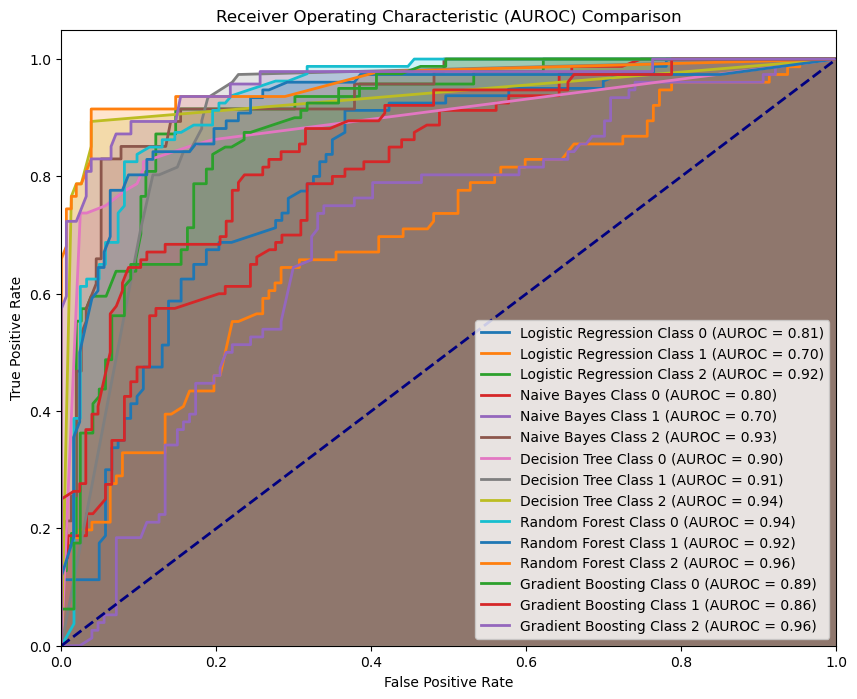

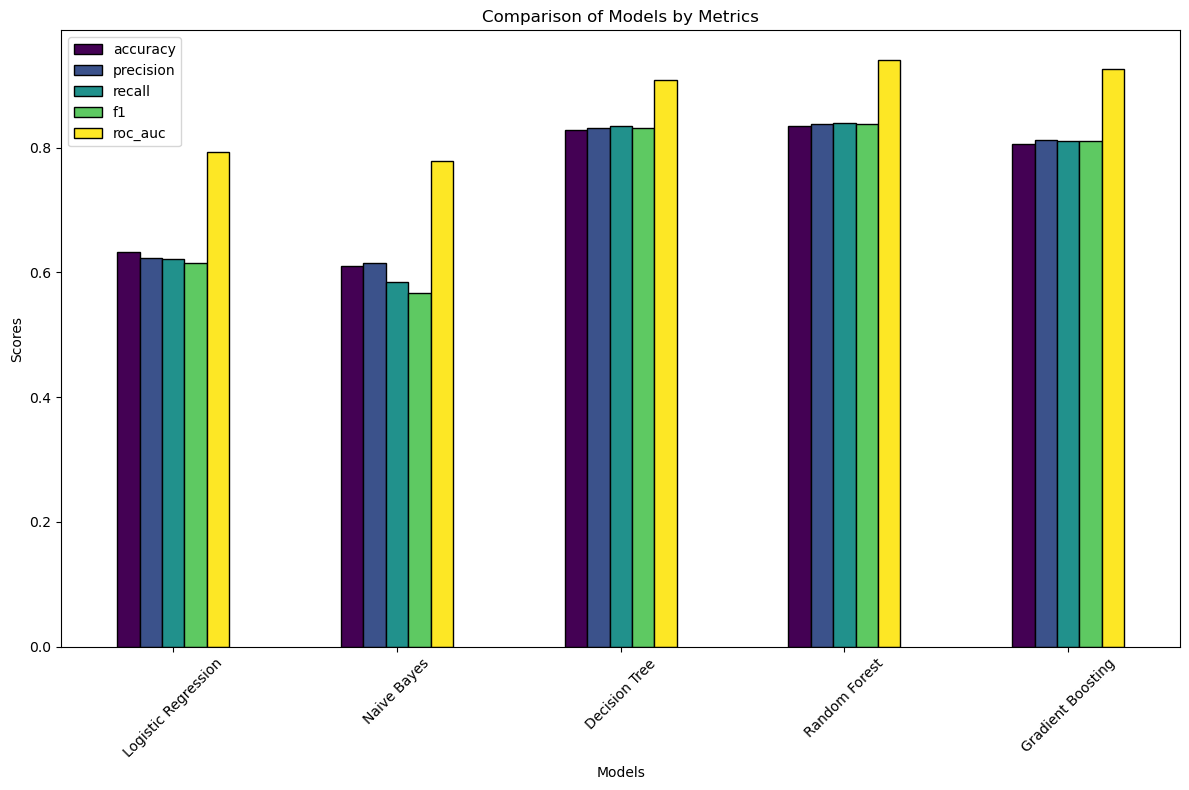

Logistic Regression: {'accuracy': 0.6325835037491478, 'precision': 0.622503473770338, 'recall': 0.6220590520590521, 'f1': 0.6151552080132118, 'roc_auc': 0.7924083814306503}
Naive Bayes: {'accuracy': 0.6103688555631296, 'precision': 0.6144571812869717, 'recall': 0.5848640248640249, 'f1': 0.5672632711462239, 'roc_auc': 0.7782694485631951}
Decision Tree: {'accuracy': 0.8286071347421041, 'precision': 0.8316558908839266, 'recall': 0.8343771043771044, 'f1': 0.8318450631857897, 'roc_auc': 0.9078333731602705}
Random Forest: {'accuracy': 0.8347799742482769, 'precision': 0.8375758162197059, 'recall': 0.8392333592333593, 'f1': 0.8376631093809097, 'roc_auc': 0.941199533770301}
Gradient Boosting: {'accuracy': 0.8064379307733092, 'precision': 0.8119193194528384, 'recall': 0.810857290857291, 'f1': 0.8100661949809149, 'roc_auc': 0.9265148670327579}


In [14]:
# prep to plot
plt.figure(figsize=(10, 8))

# cv for each model
for model_name, model in models.items():
    scores = cross_validate(model, X_train_scaled, y_train, cv=cv, scoring=scoring)
    
    # store mean scores for each metric
    results[model_name] = {
        'accuracy': np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision_macro']),
        'recall': np.mean(scores['test_recall_macro']),
        'f1': np.mean(scores['test_f1_macro']),
        'roc_auc': np.mean(scores['test_roc_auc'])
    }
    
    # for AUC curve
    # fit the model on full training dt
    model.fit(X_train_scaled, y_train)
    # predicted probabilities for pos class
    y_prob = model.predict_proba(X_test_scaled)
    
    # ROC curve
    for i in range(y_prob.shape[1]):
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} Class {i} (AUROC = {roc_auc:.2f})')
        # fill under the curve with a light shade
        plt.fill_between(fpr, tpr, alpha=0.2)
        
# plotting AUROC
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUROC) Comparison')
plt.legend(loc="lower right")
plt.show()

# bar plot for metrics
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', figsize=(12, 8), colormap='viridis', edgecolor='black')
plt.title('Comparison of Models by Metrics')
plt.ylabel('Scores')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# print results
for model_name, scores in results.items():
    print(f"{model_name}: {scores}")

In [15]:
results

{'Logistic Regression': {'accuracy': 0.6325835037491478,
  'precision': 0.622503473770338,
  'recall': 0.6220590520590521,
  'f1': 0.6151552080132118,
  'roc_auc': 0.7924083814306503},
 'Naive Bayes': {'accuracy': 0.6103688555631296,
  'precision': 0.6144571812869717,
  'recall': 0.5848640248640249,
  'f1': 0.5672632711462239,
  'roc_auc': 0.7782694485631951},
 'Decision Tree': {'accuracy': 0.8286071347421041,
  'precision': 0.8316558908839266,
  'recall': 0.8343771043771044,
  'f1': 0.8318450631857897,
  'roc_auc': 0.9078333731602705},
 'Random Forest': {'accuracy': 0.8347799742482769,
  'precision': 0.8375758162197059,
  'recall': 0.8392333592333593,
  'f1': 0.8376631093809097,
  'roc_auc': 0.941199533770301},
 'Gradient Boosting': {'accuracy': 0.8064379307733092,
  'precision': 0.8119193194528384,
  'recall': 0.810857290857291,
  'f1': 0.8100661949809149,
  'roc_auc': 0.9265148670327579}}

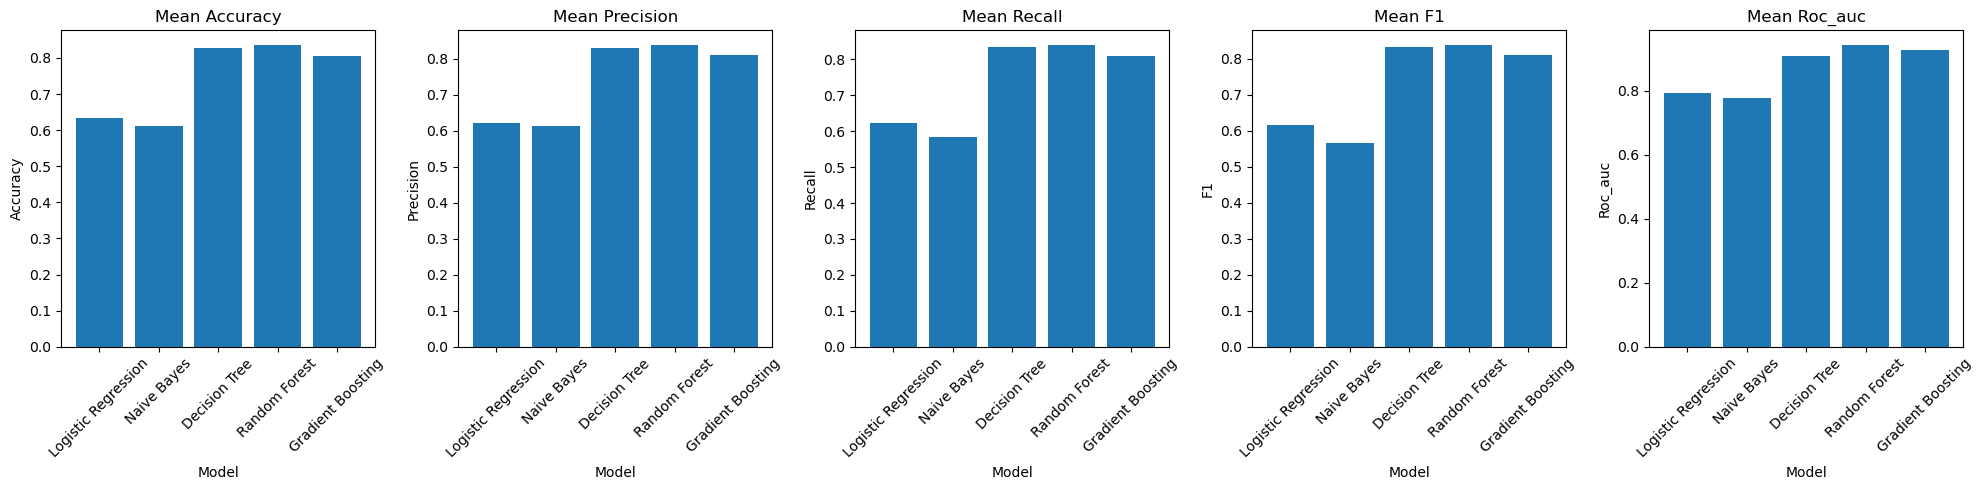

In [16]:
# this was the first plot, not included in report 
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
model_names = list(results.keys())
mean_scores = {metric: [results[model_name][metric] for model_name in model_names] for metric in metrics}

# bar plot for each metric
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

for i, metric in enumerate(metrics):
    axes[i].bar(model_names, mean_scores[metric])
    axes[i].set_title(f'Mean {metric.capitalize()}')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(f'{metric.capitalize()}')
    axes[i].set_xticks(range(len(model_names)))  
    axes[i].set_xticklabels(model_names, rotation=45) 
# layout
plt.tight_layout()
plt.show()

In [17]:
# funct to evaluate rf since this performed the best from all metrics between balanced and unbalanced
def evaluate_random_forest(X, y, cv, model):
    metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": []}
    for train_idx, val_idx in cv.split(X, y):
         # features to np array
        X = np.array(X)
        y = np.array(y)
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)
        
        # metrics
        metrics["accuracy"].append(accuracy_score(y_val, y_pred))
        metrics["precision"].append(precision_score(y_val, y_pred, average="weighted"))
        metrics["recall"].append(recall_score(y_val, y_pred, average="weighted"))
        metrics["f1"].append(f1_score(y_val, y_pred, average="weighted"))
        metrics["roc_auc"].append(roc_auc_score(y_val, y_pred_proba, multi_class="ovr"))

    # return averaged metrics
    return {metric: np.mean(scores) for metric, scores in metrics.items()}

# same K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# rf Classifier
rf_model = RandomForestClassifier(random_state=42)

# evaluate on imbalanced data
imbalanced_results = evaluate_random_forest(X, y, cv, rf_model)
print("Imbalanced:", imbalanced_results)

# balance data using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)

# evaluate on balanced data
balanced_results = evaluate_random_forest(X_balanced, y_balanced, cv, rf_model)
print("Balanced:", balanced_results)

# compare results
results_df = pd.DataFrame({"Imbalanced": imbalanced_results, "Balanced": balanced_results})
print(results_df)

Imbalanced: {'accuracy': 0.8530800370677462, 'precision': 0.8566502489028167, 'recall': 0.8530800370677462, 'f1': 0.8538725197513466, 'roc_auc': 0.9563895820255313}
Balanced: {'accuracy': 0.8272183151279366, 'precision': 0.8313855350601586, 'recall': 0.8272183151279366, 'f1': 0.8272980800003257, 'roc_auc': 0.9424751078573708}
           Imbalanced  Balanced
accuracy     0.853080  0.827218
precision    0.856650  0.831386
recall       0.853080  0.827218
f1           0.853873  0.827298
roc_auc      0.956390  0.942475


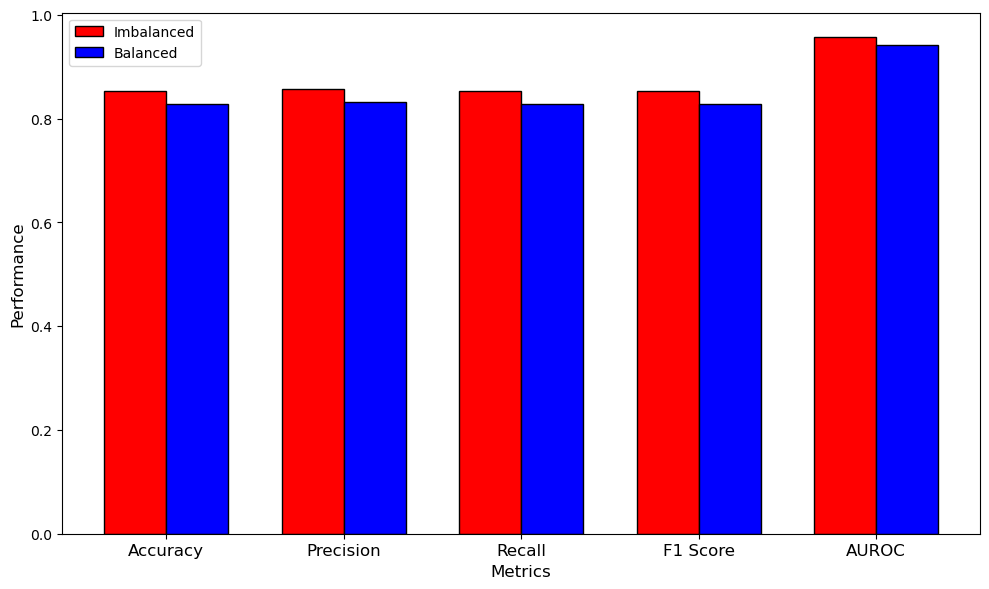

In [30]:
# plot
# results to DataFrame for plot
results_df = pd.DataFrame({
    "Metrics": ["Accuracy", "Precision", "Recall", "F1 Score", "AUROC"],
    "Imbalanced": list(imbalanced_results.values()),
    "Balanced": list(balanced_results.values())
})

# plot format
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(results_df))

# bars for imbalanced and balanced results
plt.bar(index, results_df["Imbalanced"], bar_width, label="Imbalanced", color="red", edgecolor='black')
plt.bar(index + bar_width, results_df["Balanced"], bar_width, label="Balanced", color="blue", edgecolor='black')

# format
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Performance", fontsize=12)
plt.xticks(index + bar_width / 2, results_df["Metrics"], fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

2. Cross validation
- random forest performed the best across accuracy, precision, recall, mean F1, and roc_auc
- CV with strat kfold

In [19]:
def random_forest_cv(X, y):
    # init RandomForest model
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    
    # cv with Stratified KFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='macro'),
        'recall': make_scorer(recall_score, average='macro'),
        'f1': make_scorer(f1_score, average='macro'),
        'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True)
    }
    
    # cross-validation
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    
    # return scores for each metric
    return {
        'accuracy': scores['test_accuracy'],
        'precision': scores['test_precision'],
        'recall': scores['test_recall'],
        'f1': scores['test_f1'],
        'roc_auc': scores['test_roc_auc']
    }

In [20]:
perf = random_forest_cv(X, y)
print(perf)

/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


{'accuracy': array([0.86699507, 0.84236453, 0.82758621, 0.82758621, 0.88118812]), 'precision': array([0.87091038, 0.84799466, 0.83266283, 0.84004128, 0.88427609]), 'recall': array([0.87531367, 0.8463217 , 0.82994018, 0.83496732, 0.88732265]), 'f1': array([0.87133719, 0.84606626, 0.83027789, 0.83616672, 0.88497586]), 'roc_auc': array([0.97364456, 0.95942206, 0.93666516, 0.93920397, 0.97528119])}


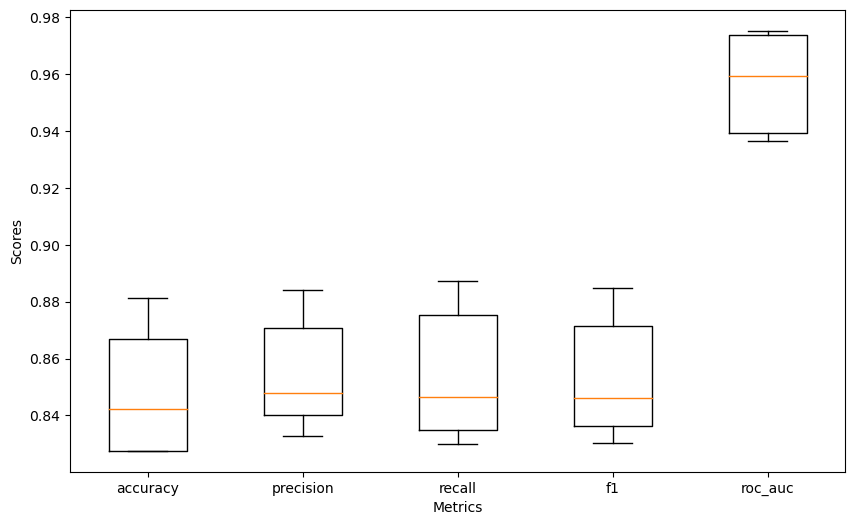

In [31]:
# box plot
# Plot box plots for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
plt.figure(figsize=(10, 6))
# box plots per metric
plt.boxplot([perf[metric] for metric in metrics], labels=metrics)

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.show()

3. Hyperparameter tuning using gridsearchcv

In [22]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None]
}

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def random_forest_cv(X, y, param_grid, cv=5):
    # split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # initialize Random Forest
    rf = RandomForestClassifier(random_state=1)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    # grid search with cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)

    # evaluate model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)

    # print best hyperparameters and accuracy
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Test Accuracy:", accuracy)
    
    # visualize with heatmap
    results = pd.DataFrame(grid_search.cv_results_)

    # Ensure no duplicate combinations of params
    heatmap_data = results.pivot_table(index="param_n_estimators", columns="param_max_depth", values="mean_test_score")

    # Plot the heatmap with annotations for values
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".3f")  # annot=True to display values in cells
    plt.title("Mean Cross-Validated Accuracy for RF Hyperparameters")
    plt.xlabel("Max Depth")
    plt.ylabel("Number of Estimators")

    # save the plot
    plt.savefig("/Users/peytonhall/downloads/random_forest_heatmap.png")
    plt.show()

    return best_model, grid_search.best_params_, accuracy

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'max_depth': None, 'n_estimators': 200}
Test Accuracy: 0.8719211822660099


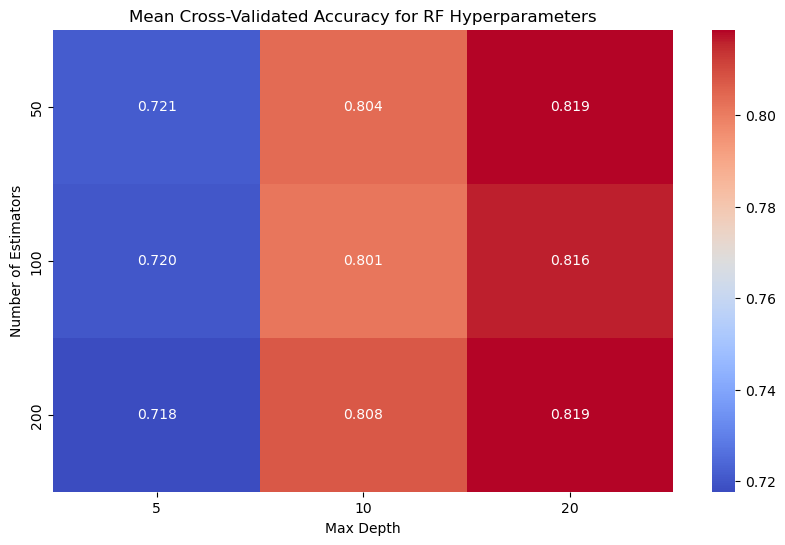

In [24]:
best_model, best_params, accuracy = random_forest_cv(X, y, param_grid, cv=5)

In [33]:
# train the final model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
# init scaler
scaler = StandardScaler()
# fit scaler on training
scaler.fit(X_train)
# transform the training data
X_train = scaler.transform(X_train)
# transform the test data using the same scaler
X_test = scaler.transform(X_test)

# define the Random Forest model with the best hyperparameters
best_rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)

# train the model on the training data
best_rf.fit(X_train, y_train)

# predict on the test data
y_pred = best_rf.predict(X_test)

# probability estimate for pos class 
y_pred_proba = best_rf.predict_proba(X_test)

# evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
# averages are set to macro bc multi-class classification
precision = metrics.precision_score(y_test, y_pred, average='macro')  
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1 = metrics.f1_score(y_test, y_pred, average='macro')
auroc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUROC: {auroc}")

Accuracy: 0.8226600985221675
Precision: 0.8345410628019323
Recall: 0.8273282941396043
F1 Score: 0.8279616829508846
AUROC: 0.9436188120356589


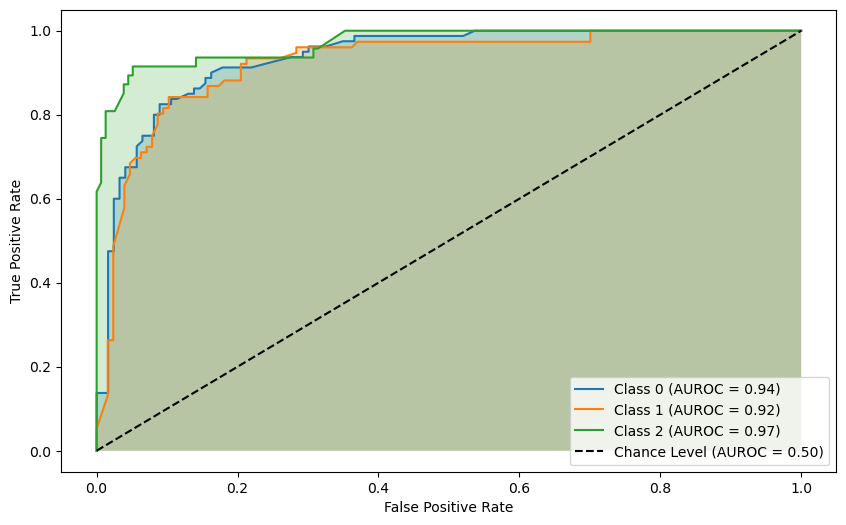

In [34]:
# plot AUROC for each class
n_classes = len(np.unique(y))  # Number of unique classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# All ROC curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUROC = {roc_auc[i]:.2f})')
    # fill under the curve with a light shade
    plt.fill_between(fpr[i], tpr[i], alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUROC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()